In [1]:
from functools import partial
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant, safe_logodds
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification
from uncertainty_testbed.uncertainty_models.hla_dropout import HLADropout, HLALinear

2022-06-22 19:07:20.162430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-22 19:07:20.162454: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train_g=100096
num_train = 33280
num_val=20000
noise_level=0.01
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train_g + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train_g:, :], y[num_train_g:]
#return x_train, y_train, x_val, y_val

In [4]:
layers = (
    keras.Input(shape=(eg.num_inputs,), name="input"),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    HLALinear(samples=100, units=1, kernel_initializer="glorot_uniform", bias_initializer="zeros",
              activation=tf.keras.activations.sigmoid, sigma_scaling=0.1, name="hla_linear")
        )
hla_classifier = HLADropout(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0056),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="HLADropout"
)
hla_classifier.fit(
    x_train,
    y_train,
    epochs=6,
    batch_size=8,
    validation_data=(x_val, y_val)
)

2022-06-22 19:09:02.928845: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-22 19:09:02.928885: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-22 19:09:02.928913: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-06-22 19:09:02.929787: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/6
4160/4160 [==============================] - 10s 2ms/step - loss: 0.3051 - hla_linear_loss: 0.3051 - hla_linear_accuracy: 0.8642 - hla_linear_auc: 0.9444 - val_loss: 0.1893 - val_hla_linear_loss: 0.1893 - val_hla_linear_accuracy: 0.9298 - val_hla_linear_auc: 0.9789
Epoch 2/6
4160/4160 [==============================] - 9s 2ms/step - loss: 0.1525 - hla_linear_loss: 0.1525 - hla_linear_accuracy: 0.9451 - hla_linear_auc: 0.9854 - val_loss: 0.1254 - val_hla_linear_loss: 0.1254 - val_hla_linear_accuracy: 0.9566 - val_hla_linear_auc: 0.9894
Epoch 3/6
4160/4160 [==============================] - 9s 2ms/step - loss: 0.1145 - hla_linear_loss: 0.1145 - hla_linear_accuracy: 0.9609 - hla_linear_auc: 0.9907 - val_loss: 0.1050 - val_hla_linear_loss: 0.1050 - val_hla_linear_accuracy: 0.9654 - val_hla_linear_auc: 0.9917
Epoch 4/6
4160/4160 [==============================] - 9s 2ms/step - loss: 0.1056 - hla_linear_loss: 0.1056 - hla_linear_accuracy: 0.9637 - hla_linear_auc: 0.9913 - val_loss:

In [5]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean, _ = hla_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles, ptiles_plus = hla_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]
p_l_plus = ptiles_plus[0, :, 0]
p_h_plus = ptiles_plus[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l_plus = np.convolve(p_l_plus[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h_plus = np.convolve(p_h_plus[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

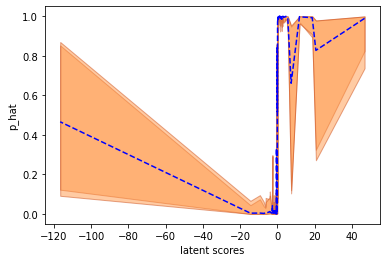

In [6]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.fill_between(scores, p_l_plus, p_h_plus, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

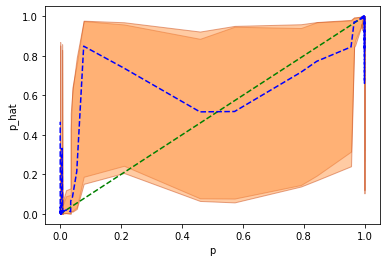

In [7]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.fill_between(probs, p_l_plus, p_h_plus, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [8]:
print (p_l[:10])
print (p_l_plus[:10])

[0.82445734 0.32455916 0.89289779 0.9674582  0.95727957 0.12021952
 0.92189145 0.97917976 0.98952827 0.97888703]
[0.73693637 0.27152484 0.90763335 0.96170464 0.95797877 0.10375318
 0.92171039 0.97864137 0.98751401 0.97427623]


In [9]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean, _ = hla_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles, ptiles_plus = hla_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]
p_l_plus = ptiles_plus[0, :, 0]
p_h_plus = ptiles_plus[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

2022-06-22 19:10:02.706723: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.
2022-06-22 19:11:45.153647: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


For noise level: 0.01: 83.65% within 90% CI


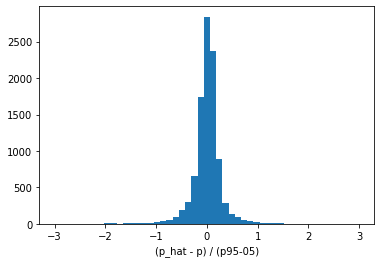

In [10]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.01: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

For noise level: 0.01: 86.31% within 90% CI


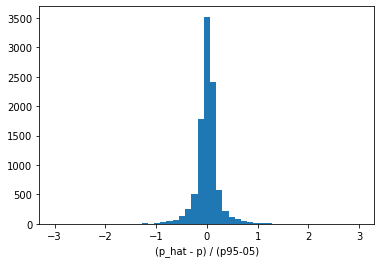

In [11]:
inside = np.logical_and(np.less_equal(p_l_plus, probs), np.less_equal(probs, p_h_plus))
print ("For noise level: 0.01: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h_plus - p_l_plus)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

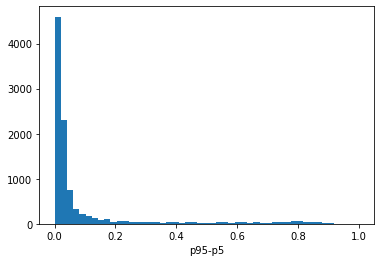

In [12]:
plt.hist(p_h - p_l, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()

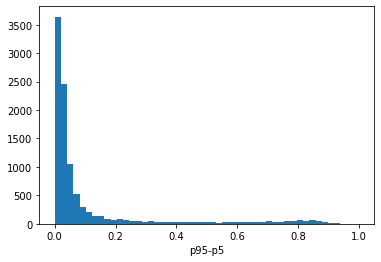

In [13]:
plt.hist(p_h_plus - p_l_plus, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()

In [14]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train_g=100096
num_train = 33280
num_val=20000
noise_level=0.1
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train_g + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train_g:, :], y[num_train_g:]
#return x_train, y_train, x_val, y_val

In [15]:
layers = (
    keras.Input(shape=(eg.num_inputs,), name="input"),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    HLALinear(samples=100, units=1, kernel_initializer="glorot_uniform", bias_initializer="zeros",
              activation=tf.keras.activations.sigmoid, sigma_scaling=0.1, name="hla_linear")
        )
hla_classifier = HLADropout(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0056),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="HLADropout"
)
hla_classifier.fit(
    x_train,
    y_train,
    epochs=6,
    batch_size=8,
    validation_data=(x_val, y_val)
)

Epoch 1/6
4160/4160 [==============================] - 11s 2ms/step - loss: 0.3996 - hla_linear_loss: 0.3996 - hla_linear_accuracy: 0.8311 - hla_linear_auc: 0.9078 - val_loss: 0.3171 - val_hla_linear_loss: 0.3171 - val_hla_linear_accuracy: 0.8827 - val_hla_linear_auc: 0.9404
Epoch 2/6
4160/4160 [==============================] - 10s 2ms/step - loss: 0.2737 - hla_linear_loss: 0.2737 - hla_linear_accuracy: 0.9019 - hla_linear_auc: 0.9533 - val_loss: 0.2663 - val_hla_linear_loss: 0.2663 - val_hla_linear_accuracy: 0.9071 - val_hla_linear_auc: 0.9563
Epoch 3/6
4160/4160 [==============================] - 9s 2ms/step - loss: 0.2496 - hla_linear_loss: 0.2496 - hla_linear_accuracy: 0.9125 - hla_linear_auc: 0.9594 - val_loss: 0.2586 - val_hla_linear_loss: 0.2586 - val_hla_linear_accuracy: 0.9096 - val_hla_linear_auc: 0.9575
Epoch 4/6
4160/4160 [==============================] - 10s 2ms/step - loss: 0.2387 - hla_linear_loss: 0.2387 - hla_linear_accuracy: 0.9171 - hla_linear_auc: 0.9617 - val_los

In [16]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean, _ = hla_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles, ptiles_plus = hla_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]
p_l_plus = ptiles_plus[0, :, 0]
p_h_plus = ptiles_plus[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l_plus = np.convolve(p_l_plus[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h_plus = np.convolve(p_h_plus[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

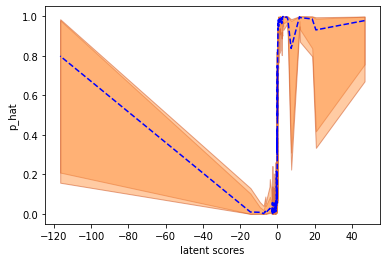

In [17]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.fill_between(scores, p_l_plus, p_h_plus, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

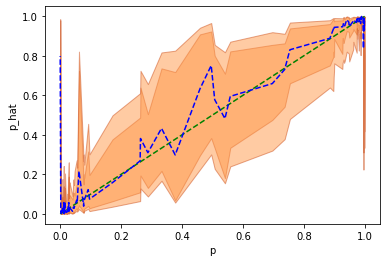

In [18]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.fill_between(probs, p_l_plus, p_h_plus, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [19]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean, _ = hla_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles, ptiles_plus = hla_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]
p_l_plus = ptiles_plus[0, :, 0]
p_h_plus = ptiles_plus[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

2022-06-22 19:23:00.028993: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.
2022-06-22 19:24:47.543233: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


For noise level: 0.1: 91.88% within 90% CI


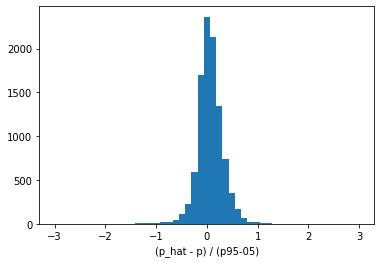

In [20]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.1: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

For noise level: 0.1: 94.99% within 90% CI


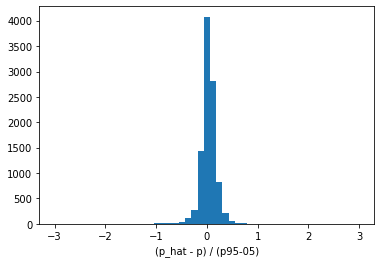

In [21]:
inside = np.logical_and(np.less_equal(p_l_plus, probs), np.less_equal(probs, p_h_plus))
print ("For noise level: 0.1: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h_plus - p_l_plus)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

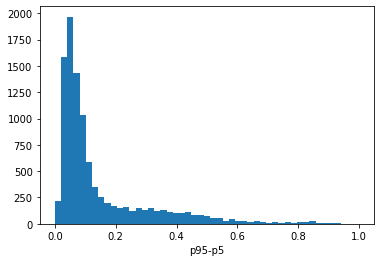

In [22]:
plt.hist(p_h - p_l, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()

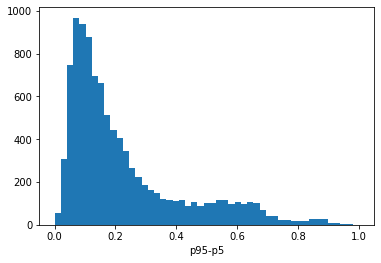

In [23]:
plt.hist(p_h_plus - p_l_plus, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()

In [24]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train_g=100096
num_train = 33280
num_val=20000
noise_level=0.3
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train_g + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train_g:, :], y[num_train_g:]
#return x_train, y_train, x_val, y_val

In [25]:
layers = (
    keras.Input(shape=(eg.num_inputs,), name="input"),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    HLALinear(samples=100, units=1, kernel_initializer="glorot_uniform", bias_initializer="zeros",
              activation=tf.keras.activations.sigmoid, sigma_scaling=0.1, name="hla_linear")
        )
hla_classifier = HLADropout(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0056),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="HLADropout"
)
hla_classifier.fit(
    x_train,
    y_train,
    epochs=6,
    batch_size=8,
    validation_data=(x_val, y_val)
)

Epoch 1/6
4160/4160 [==============================] - 11s 2ms/step - loss: 0.5200 - hla_linear_loss: 0.5200 - hla_linear_accuracy: 0.7562 - hla_linear_auc: 0.8295 - val_loss: 0.4328 - val_hla_linear_loss: 0.4328 - val_hla_linear_accuracy: 0.8174 - val_hla_linear_auc: 0.8857
Epoch 2/6
4160/4160 [==============================] - 10s 2ms/step - loss: 0.4134 - hla_linear_loss: 0.4134 - hla_linear_accuracy: 0.8279 - hla_linear_auc: 0.8946 - val_loss: 0.4017 - val_hla_linear_loss: 0.4017 - val_hla_linear_accuracy: 0.8334 - val_hla_linear_auc: 0.9011
Epoch 3/6
4160/4160 [==============================] - 10s 2ms/step - loss: 0.3920 - hla_linear_loss: 0.3920 - hla_linear_accuracy: 0.8378 - hla_linear_auc: 0.9047 - val_loss: 0.3937 - val_hla_linear_loss: 0.3937 - val_hla_linear_accuracy: 0.8403 - val_hla_linear_auc: 0.9096
Epoch 4/6
4160/4160 [==============================] - 10s 2ms/step - loss: 0.3820 - hla_linear_loss: 0.3820 - hla_linear_accuracy: 0.8418 - hla_linear_auc: 0.9096 - val_lo

In [26]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean, _ = hla_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles, ptiles_plus = hla_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]
p_l_plus = ptiles_plus[0, :, 0]
p_h_plus = ptiles_plus[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l_plus = np.convolve(p_l_plus[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h_plus = np.convolve(p_h_plus[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

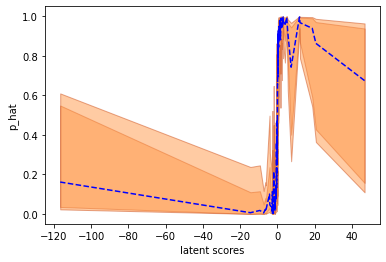

In [27]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.fill_between(scores, p_l_plus, p_h_plus, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

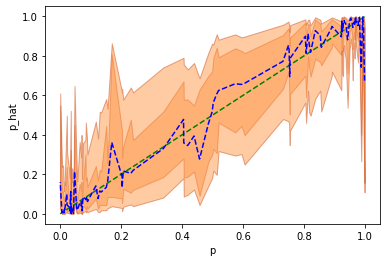

In [28]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.fill_between(probs, p_l_plus, p_h_plus, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [29]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean, _ = hla_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles, ptiles_plus = hla_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]
p_l_plus = ptiles_plus[0, :, 0]
p_h_plus = ptiles_plus[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

2022-06-23 11:02:50.023145: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


For noise level: 0.3: 88.46000000000001% within 90% CI


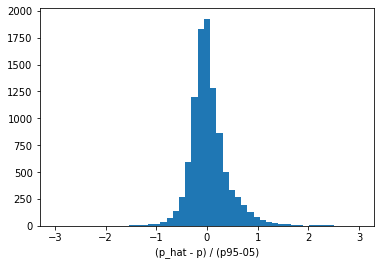

In [30]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.3: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

For noise level: 0.3: 95.85000000000001% within 90% CI


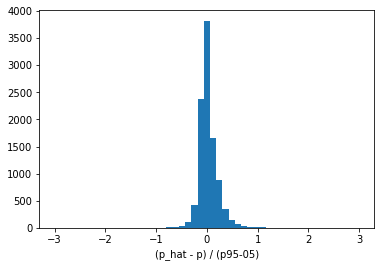

In [31]:
inside = np.logical_and(np.less_equal(p_l_plus, probs), np.less_equal(probs, p_h_plus))
print ("For noise level: 0.3: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h_plus - p_l_plus)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

Percentage of 90% CI below 0.2: 0.6202
Average p95: 0.6066053199388087


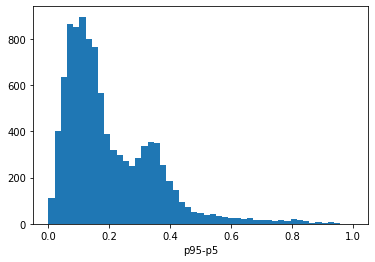

In [38]:
thr = 0.2
print("Percentage of 90% CI below {}: {}". format(thr, np.mean(np.less_equal(p_h - p_l, thr))))
print("Average p95: {}".format(np.mean(p_h)))

plt.hist(p_h - p_l, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()

Percentage of 90% CI below 0.2: 0.2083
Average p95: 0.7054114824745286


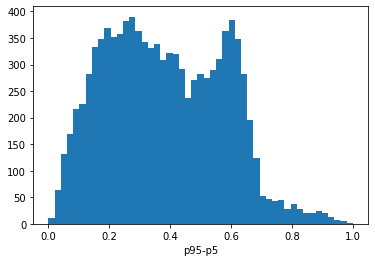

In [39]:
thr = 0.2
print("Percentage of 90% CI below {}: {}". format(thr, np.mean(np.less_equal(p_h_plus - p_l_plus, thr))))
print("Average p95: {}".format(np.mean(p_h_plus)))

plt.hist(p_h_plus - p_l_plus, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()